In [1]:
import requests
import zipfile
import io
# downloading the dataset

url = "https://archive.ics.uci.edu/static/public/445/absenteeism+at+work.zip"
response = requests.get(url)
if response.status_code == 200:
    print("Successfully fetched the webpage.")
else:
    print(f"Failed to fetch the webpage. Status code: {response.status_code}")
filename = "Attribute Information.docx"
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    # List all files in the zip
    print(z.namelist())
    # Extract the csv file
    z.extract("Absenteeism_at_work.csv", path=".")
    print("Extracted Absenteeism_at_work.csv")
    z.extract(filename, path=".")

import docx

doc = docx.Document(filename)
fullText = []
for para in doc.paragraphs:
    fullText.append(para.text)
text = '\n'.join(fullText)
# regex
import re
# filter out anything before \nI
texst = re.search(r'\nI.*?\(28\)', text, re.DOTALL).group(0)
texst = texst.split('\n')
texst = [i for i in texst if i != '']
texsst = [(' ').join(i.split(' ')[1:]).strip() for i in texst[:21]] + [i.split(' (')[0] for i in texst[21].split('CID) ')[1].split(', ')]
texsst = [i.capitalize().split('.')[0] for i in texsst]
absence_reasons = {}
for i in range(len(texsst)):
    absence_reasons[i+1] = texsst[i]
absence_reasons[0] = 'No Absence'


Successfully fetched the webpage.
['Absenteeism_at_work.arff', 'Absenteeism_at_work.csv', 'Absenteeism_at_work.xls', 'Attribute Information.docx', 'UCI_ABS_TEXT.docx']
Extracted Absenteeism_at_work.csv


In [2]:
import pandas as pd
df = pd.read_csv("Absenteeism_at_work.csv", sep=";")
#df['Reason for absence'] = df['Reason for absence'].map(absence_reasons)
# Investigating datapoint distribution for each employee (ID)
df['ID'].value_counts()

# find the first index of month being 1
year_breaks = []
if df.iloc[0,:]['Month of absence'] != 1:
    year_breaks.append(df[df['Month of absence'] == 1].index[0])
else:
    year_breaks.append(df.index[0])

df_1 = df[df['Month of absence'] == 1]
for idx in range(1, len(df_1.index)):
    if df_1.index[idx] - df_1.index[idx-1] > 1:
        year_breaks.append(df_1.index[idx])
year_breaks.append(df.index[-1])
df['Year'] = 1
for i in range(0,len(year_breaks)-1):
    df.loc[year_breaks[i]:year_breaks[i+1], 'Year'] = i+2

    
from functions import map_reason_category
df['reason_group'] = df['Reason for absence'].map(map_reason_category)

In [74]:
from functions import duration_stats
duration_stats_all = duration_stats(df, 'Reason for absence')
duration_stats_all['Reason for absence'] = duration_stats_all['Reason for absence'].map(absence_reasons)
print(duration_stats_all)
df['reason_group'] = df['Reason for absence'].apply(map_reason_category)
duration_stats_grouped = duration_stats(df, 'reason_group')

duration_stats_grouped.to_csv('duration_stats_grouped.csv')

                                   Reason for absence  median  mean  \
0                                           Neoplasms    24.0  24.0   
1                  Diseases of the circulatory system    24.0  42.0   
2        Diseases of the skin and subcutaneous tissue    10.0  23.4   
3   Diseases of the blood and blood-forming organs...     8.0   8.0   
4                    Diseases of the digestive system     8.0  11.4   
5                    Mental and behavioural disorders     8.0   6.3   
6                      Diseases of the eye and adnexa     8.0  10.0   
7                      Diseases of the nervous system     8.0  21.4   
8                  Diseases of the respiratory system     8.0  11.0   
9            Pregnancy, childbirth and the puerperium     8.0   8.0   
10  Diseases of the musculoskeletal system and con...     8.0  15.3   
11          Certain infectious and parasitic diseases     8.0  11.4   
12                                     Blood donation     8.0   8.0   
13    

Future: validate grouping -> see if patterns stay the same within group

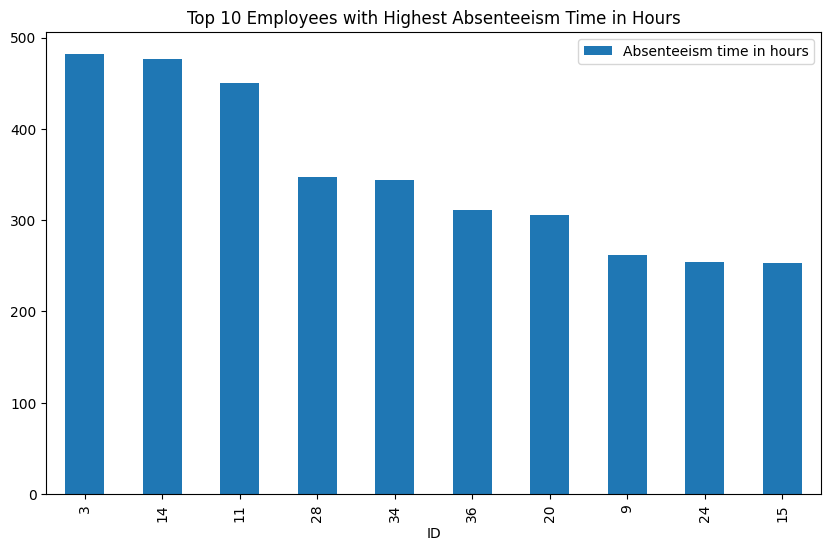

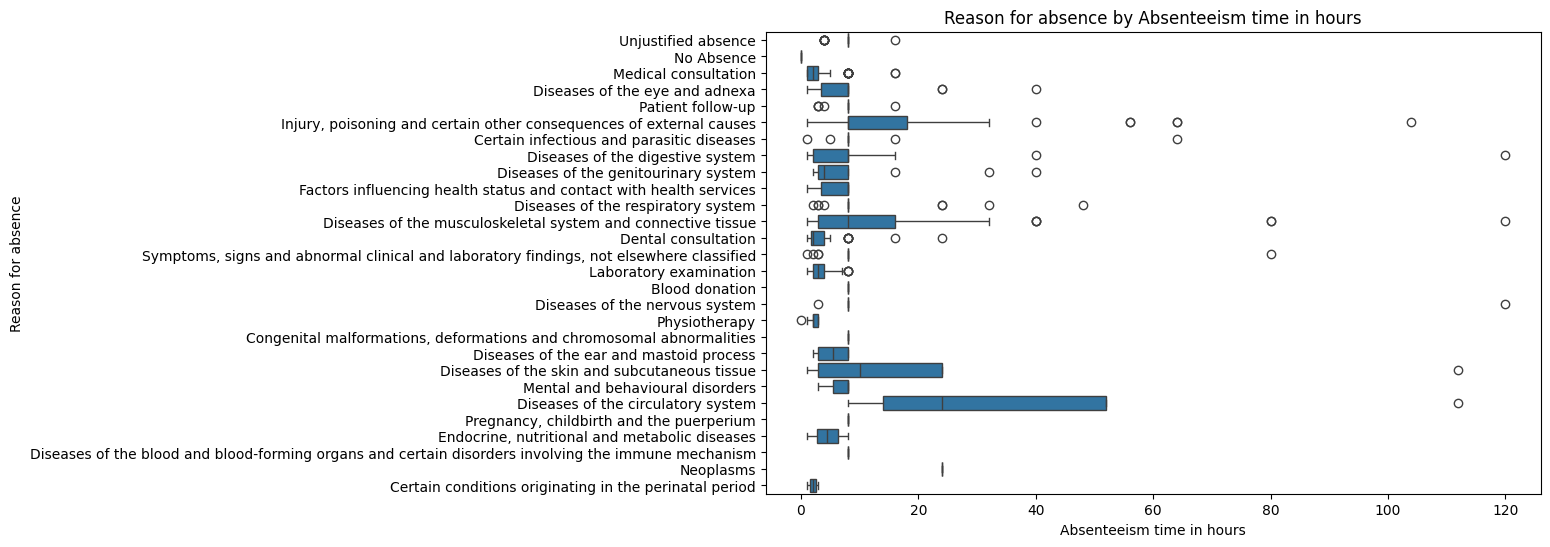

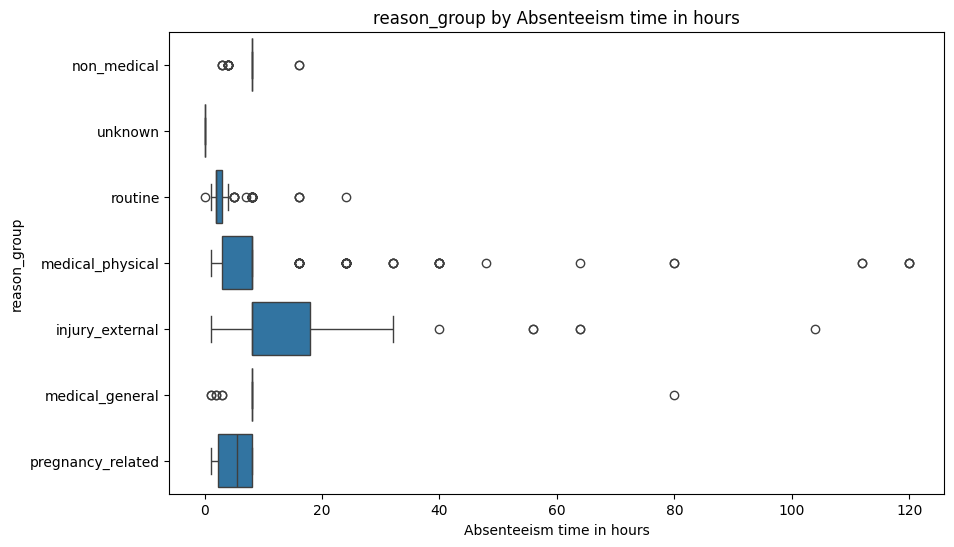

In [4]:
from functions import boxplot_distribution
# plot sum of absenteeism time in hours for each person
df.groupby('ID')['Absenteeism time in hours'].sum().reset_index().sort_values(by='Absenteeism time in hours', ascending=False).head(10).plot(x='ID', y='Absenteeism time in hours', kind='bar', figsize=(10, 6), title='Top 10 Employees with Highest Absenteeism Time in Hours')
df_mapped = df.copy()
df_mapped['Reason for absence'] = df_mapped['Reason for absence'].map(absence_reasons)
boxplot_distribution(df_mapped, 'Absenteeism time in hours','Reason for absence')
boxplot_distribution(df_mapped, 'Absenteeism time in hours','reason_group')

Reason for absence
0    40
Name: count, dtype: int64


<Axes: title={'center': 'Work Load Average per Day for Employee ID 3'}, xlabel='Month of absence'>

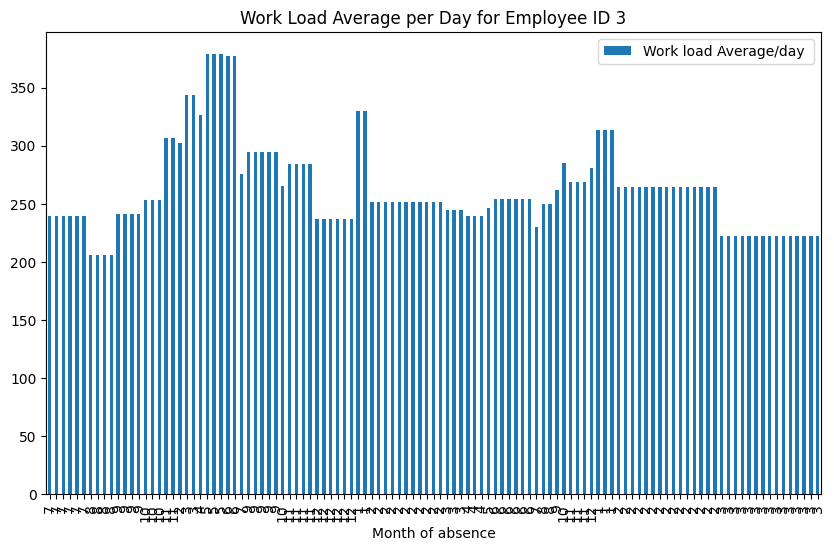

In [5]:
print(df[df['Disciplinary failure'] == 1]['Reason for absence'].value_counts())
ids_reasonforabs = df[(df['Reason for absence'] == 0) & (df['Disciplinary failure'] == 0)]['ID'].to_list()
df.drop(df[(df['ID'].isin(ids_reasonforabs)) & (df['Disciplinary failure'] == 0)].index, inplace=True)
# found one incorrect data point for no absences (this person has a disciplinary failure)
# reason for absence 0 represents either a disciplinary failure (most likely getting fired) or no absences

# plot work load average over time
df[df['ID'] == 3].reset_index(drop=True).plot(x='Month of absence', y='Work load Average/day ', kind='bar', figsize=(10, 6), title='Work Load Average per Day for Employee ID 3')
# Workload is the average per day of a given month.

In [ ]:
# Finding the columns that have no std and are thus personal information
indi_columns = []
nonindi_columns = []
for i in df['ID'].unique():
    if df[df['ID'] == i].shape[0] > 10:
        df_individual = df[df['ID'] == i]
        print(f"Individual {i} has {df_individual.shape[0]} absences")
        break
for column in df_individual.columns:
    # print the std of the column
    # if columns contains non numeric values, add it to the nonindi_columns and continue
    if df_individual[column].dtype == 'object':
        print(f"Column {column} is non numeric")
        nonindi_columns.append(column)
        continue
    if df_individual[column].std() == 0:
        print(f"Column {column} has no std")
        indi_columns.append(column)
    else:
        print(f"Column {column} has std {df_individual[column].std()}")
        nonindi_columns.append(column)
    
# create a new dataframe with only the individual columns
indi_df = df[indi_columns]

# drop duplicate ids, keep the first one
indi_df.drop_duplicates(subset=['ID'], keep='first', inplace=True)
indi_df.set_index("ID", inplace=True)
indi_df.sort_index(inplace=True)

# make a columns for whether a person has had a disciplinary failure or not
discp_per_id = df.groupby('ID')['Disciplinary failure'].sum()
discp_per_id = discp_per_id.map(lambda x: 1 if x > 0 else 0)
indi_df['Disciplinary failure'] = discp_per_id

# make a columns for the total absenteeism time in hours
indi_df['Total Absenteeism Time'] = df.groupby('ID')['Absenteeism time in hours'].sum()

# make a column for the amount of absence time that is unjustified absence (26 in category of absence)
unjust_dict  = df[df['Reason for absence'] == 26].groupby('ID')['Absenteeism time in hours'].sum().to_dict()
for i in df['ID'].unique():
    if i not in unjust_dict.keys():
        unjust_dict[int(i)] = 0
# sort the keys in the dictionary by numeric value
unjust_dict = dict(sorted(unjust_dict.items()))
indi_df['Unjustified Absence Time'] = unjust_dict.values()
indi_df['avg_wl'] = df.groupby('ID')['Work load Average/day '].mean()

# modelin

Individual 11 has 40 absences
Column ID has no std
Column Reason for absence has std 6.621642835894567
Column Month of absence has std 3.2486683662458
Column Day of the week has std 1.320207831346534
Column Seasons has std 1.2025613689761725
Column Transportation expense has no std
Column Distance from Residence to Work has no std
Column Service time has no std
Column Age has no std
Column Work load Average/day  has std 43.88726102079843
Column Hit target has std 3.7997975654581313
Column Disciplinary failure has std 0.22072142786315221
Column Education has no std
Column Son has no std
Column Social drinker has no std
Column Social smoker has no std
Column Pet has no std
Column Weight has no std
Column Height has no std
Column Body mass index has no std
Column Absenteeism time in hours has std 16.4935884979122
Column Year has std 0.8929926637077695
Column reason_group is non numeric


C:\Users\Tijn\AppData\Local\Temp\ipykernel_7740\3466232716.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indi_df.drop_duplicates(subset=['ID'], keep='first', inplace=True)
C:\Users\Tijn\AppData\Local\Temp\ipykernel_7740\3466232716.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indi_df.sort_index(inplace=True)
C:\Users\Tijn\AppData\Local\Temp\ipykernel_7740\3466232716.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

#### Not enough instances in the individual dataframe to make even remotely accuracte predictions, but it seems that for disciplinary failure -> distance to work and unjustified absences are positively correlated

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from functions import extract_plot_FI

df['previous absences'] = 0
for i in df['ID'].unique():
    count = 0
    for j in df[df['ID'] == i].index:
        if df.loc[j, 'Absenteeism time in hours'] > 0:
            df.loc[j, 'previous absences'] = count
        count += 1
df['Long absence'] = df['Absenteeism time in hours'].map(lambda x: 1 if x >= 40 else 0)
# one-hot encoding: 'day of the week', 'month of absence', 'reason for absence', 'seasons'
#df['Reason for absence'] = df['Reason for absence'].map(absence_reasons)
df['Day of the week'] = df['Day of the week'].map(lambda x: 'Monday' if x == 2 else 'Tuesday' if x == 3 else 'Wednesday' if x == 4 else 'Thursday' if x == 5 else 'Friday' if x == 6 else x)
df['Month of absence'] = df['Month of absence'].map(lambda x: 'January' if x == 1 else 'February' if x == 2 else 'March' if x == 3 else 'April' if x == 4 else 'May' if x == 5 else 'June' if x == 6 else 'July' if x == 7 else 'August' if x == 8 else 'September' if x == 9 else 'October' if x == 10 else 'November' if x == 11 else x)
df = pd.get_dummies(df, columns=['Day of the week', 'Month of absence', 'reason_group', 'Seasons'])


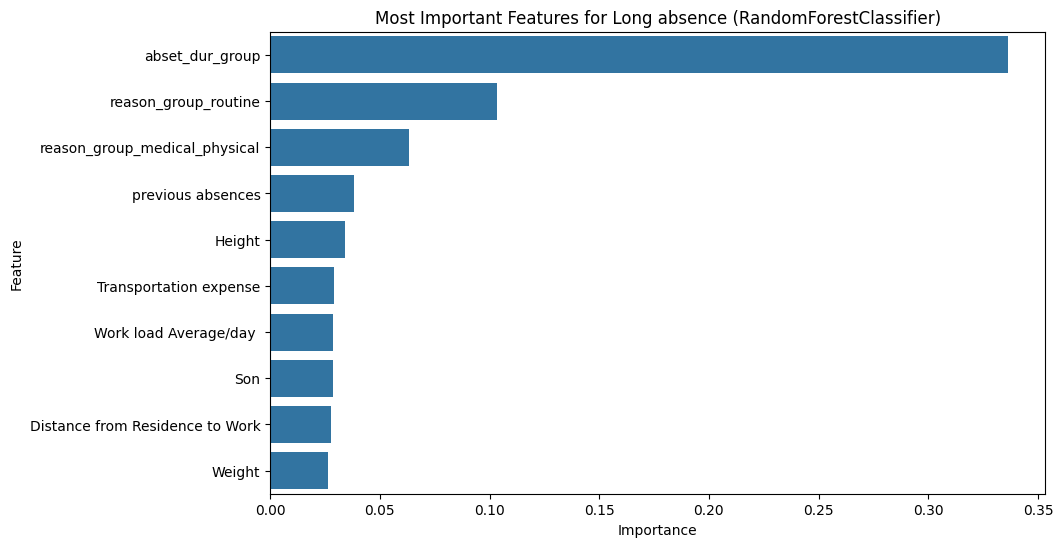

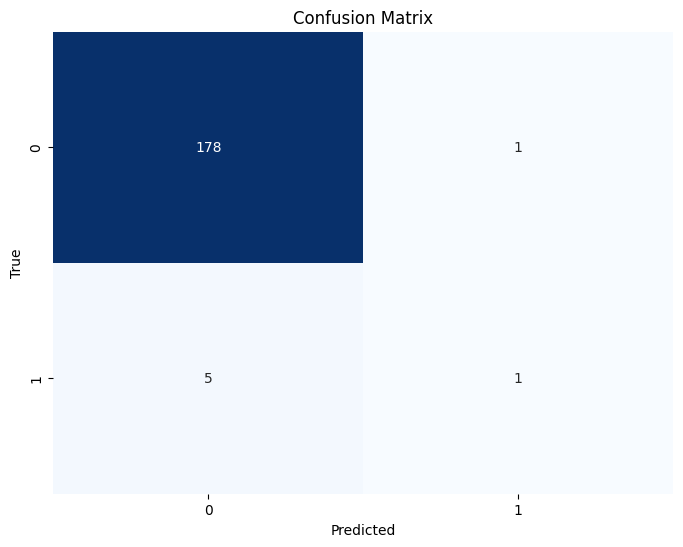

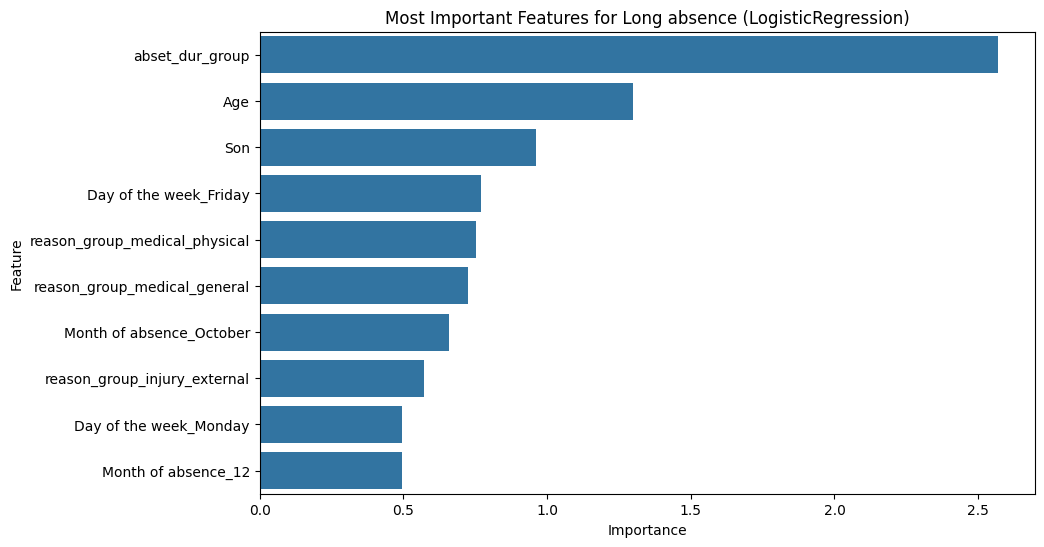

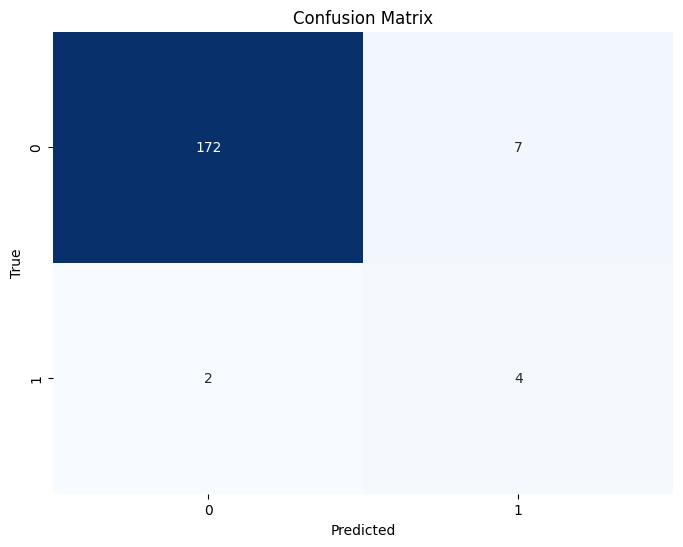

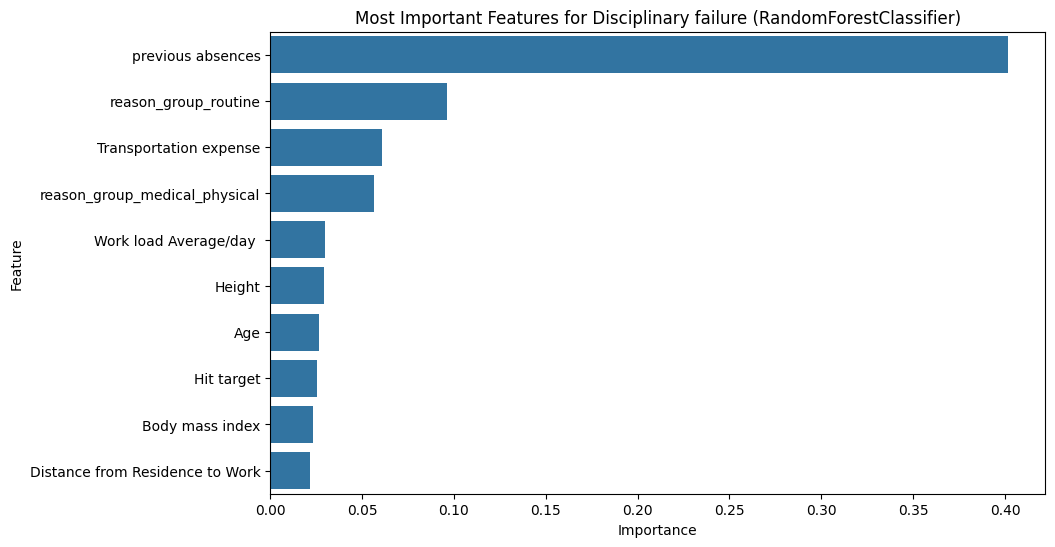

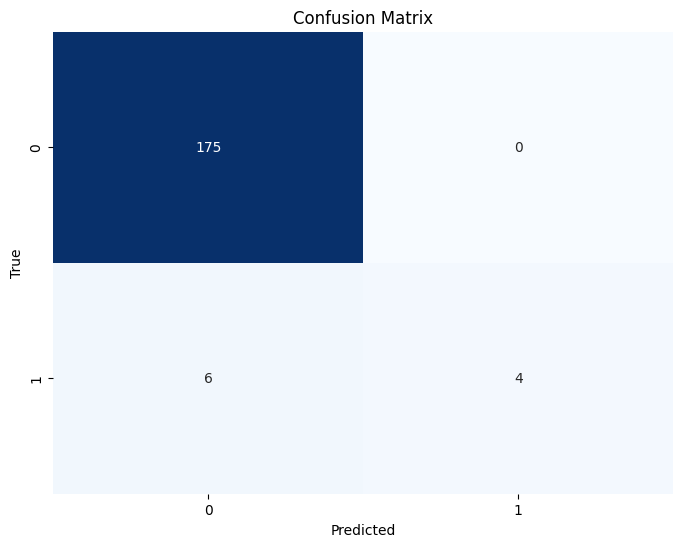

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', RandomForestClassifier(class_weight='balanced'))])

In [29]:

# Let's predict Long absence with the new features
X = df.drop(columns=['Long absence', 'ID', 'Absenteeism time in hours'])
# drop all columns that contain 'Reason for absence' in the name
for column in X.columns:
    if 'Reason for absence' in column:
        X.drop(columns=[column], inplace=True)
y = df['Long absence']
extract_plot_FI(X, y, RandomForestClassifier(class_weight='balanced'))
# only predicts 0s, despite the class weights
# let's try with a logistic regression model

class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights = dict(enumerate(class_weights))
model = LogisticRegression(class_weight=class_weights)
extract_plot_FI(X, y, model)

# predict disciplinary failure with the new features
X = df.drop(columns=['Disciplinary failure', 'ID', 'Absenteeism time in hours', 'Reason for absence', 'reason_group_unknown'])
y = df['Disciplinary failure']
extract_plot_FI(X, y, RandomForestClassifier(class_weight='balanced'))


Mean Squared Error: 47.57799837837838
R^2 Score: 0.47401533726378664


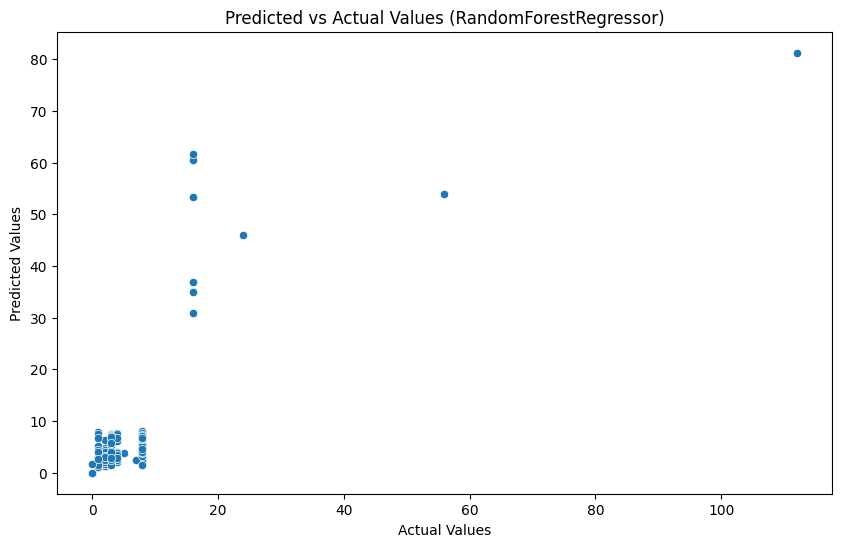

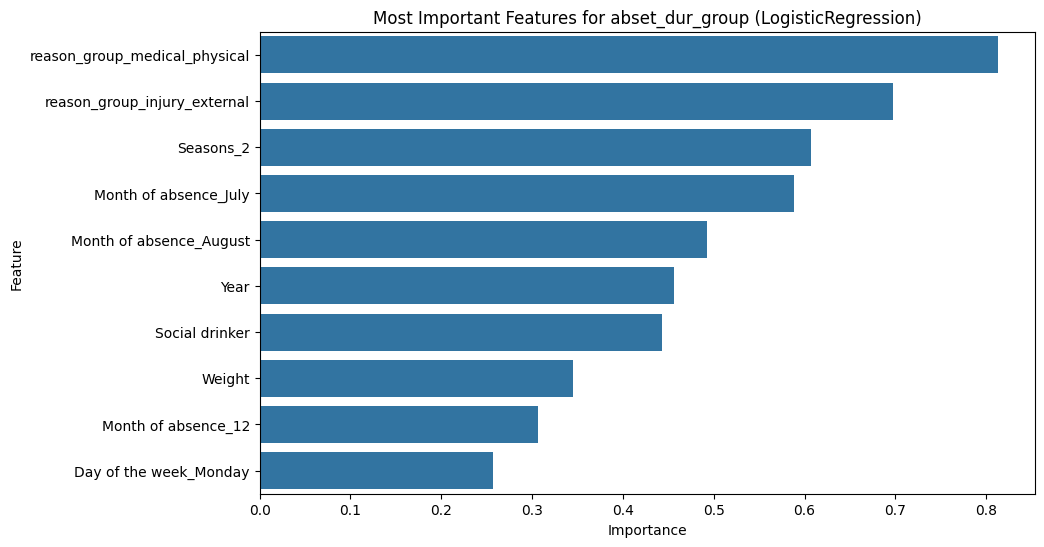

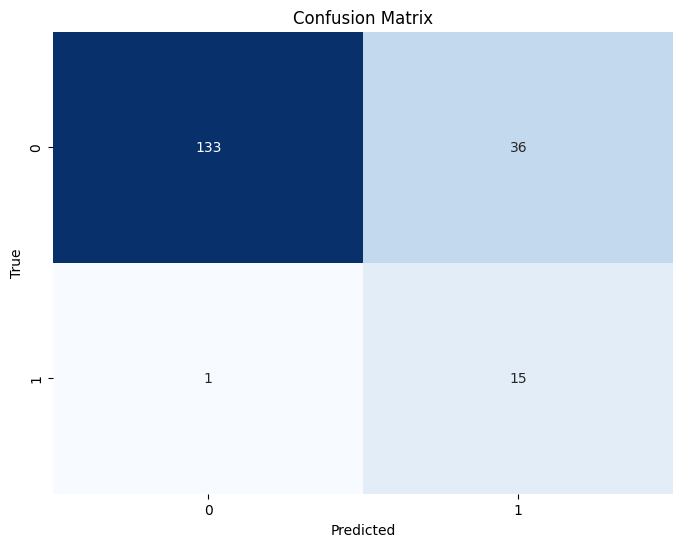

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(class_weight='balanced'))])

In [30]:
# predict how many hours of absence a person will have
X = df.drop(columns=['Absenteeism time in hours', 'ID', 'Long absence', 'Disciplinary failure'])
y = df['Absenteeism time in hours']
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

pipeline = extract_plot_FI(X, y, RandomForestRegressor(), regression=True)

# predict class of hours of absence
from functions import bracket_data
absent_sums = df.groupby(['ID'])['Absenteeism time in hours'].sum()
# bracketing the data into 4 groups
import numpy as np
bins = [-np.inf, 8, np.inf]
df['abset_dur_group'] = bracket_data(df['Absenteeism time in hours'], bins)

X = df.drop(columns=['abset_dur_group', 'ID', 'Long absence', 'Disciplinary failure', 'Absenteeism time in hours', 'Reason for absence'])
y = df['abset_dur_group']
extract_plot_FI(X, y, LogisticRegression(class_weight='balanced'))


In [ ]:
X = df.drop(columns=['Absenteeism time in hours bracketed', 'ID', 'Long absence', 'Disciplinary failure'])
y = df['Absenteeism time in hours bracketed']
extract_plot_FI(X, y, RandomForestClassifier(class_weight='balanced'))

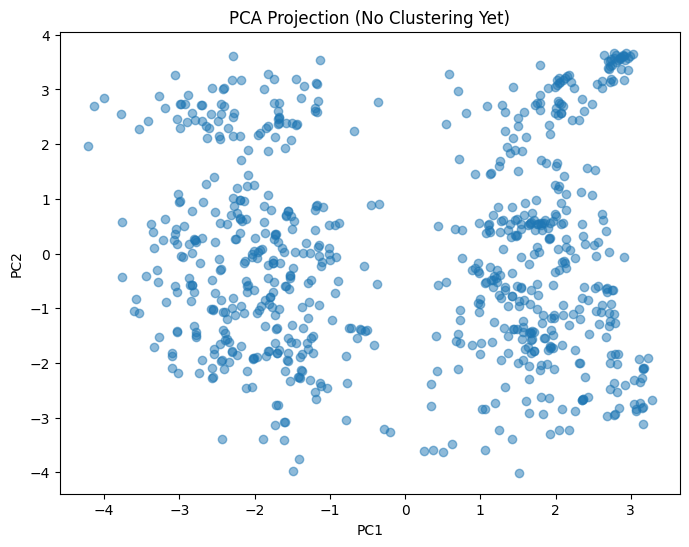

In [61]:
# Drop irrelevant or redundant columns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
df_pca = df.drop(columns=["ID", "Absenteeism time in hours", "Reason for absence", "Disciplinary failure"])
df_pca

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_pca)

# Optional: reduce dimensions with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot PCA to get a feel
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.title("PCA Projection (No Clustering Yet)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


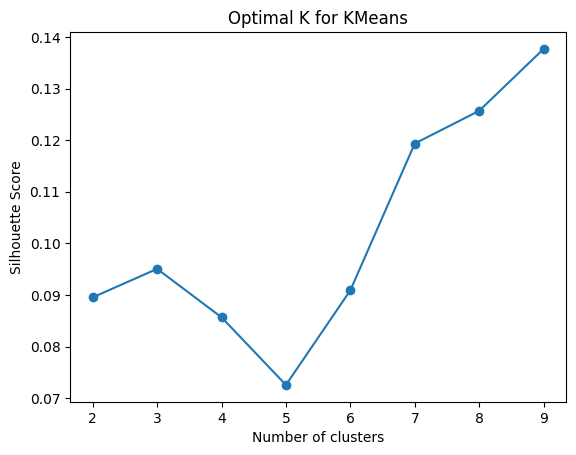

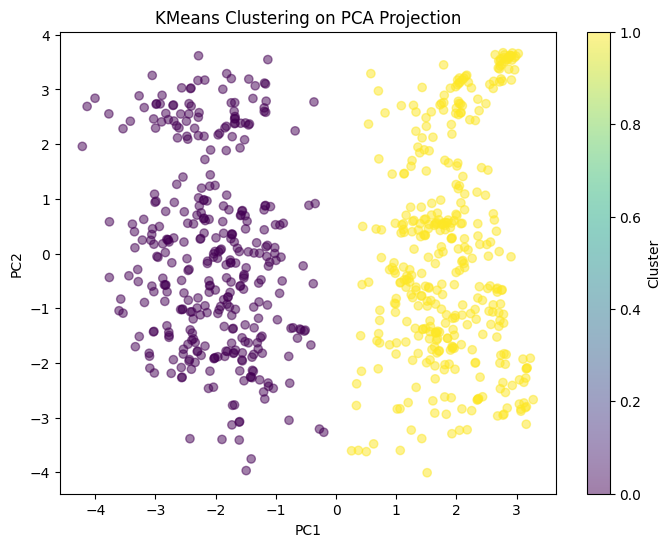

In [72]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# Try different K values
scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    scores.append(score)

plt.plot(range(2, 10), scores, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.title("Optimal K for KMeans")
plt.show()
kmeans = KMeans(n_clusters=2, random_state=42)
df["cluster"] = kmeans.fit_predict(X_scaled)
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df["cluster"], cmap='viridis', alpha=0.5)
plt.title("KMeans Clustering on PCA Projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Cluster')
plt.show()

In [ ]:
cluster_means = df.groupby("cluster").mean(numeric_only=True)
cluster_means.T.sort_values(by=0, ascending=False)


cluster,0,1
Work load Average/day,261.687256,280.652110
Transportation expense,231.873596,211.834646
Height,171.443820,172.745407
Hit target,92.550562,96.488189
Weight,79.651685,78.359580
Age,36.460674,36.380577
Distance from Residence to Work,30.148876,29.133858
Body mass index,27.081461,26.262467
Reason for absence,18.738764,19.813648
ID,17.573034,18.451444


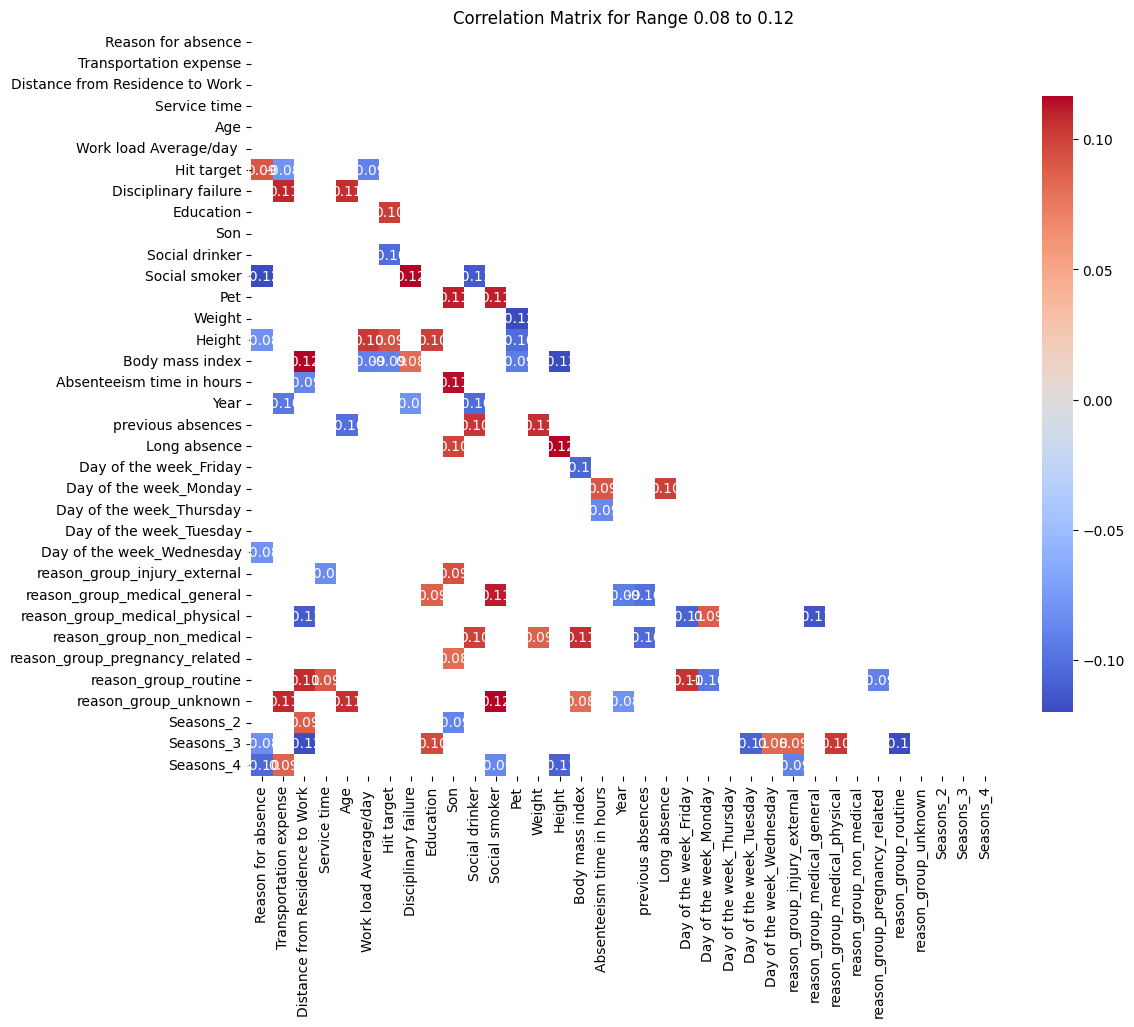

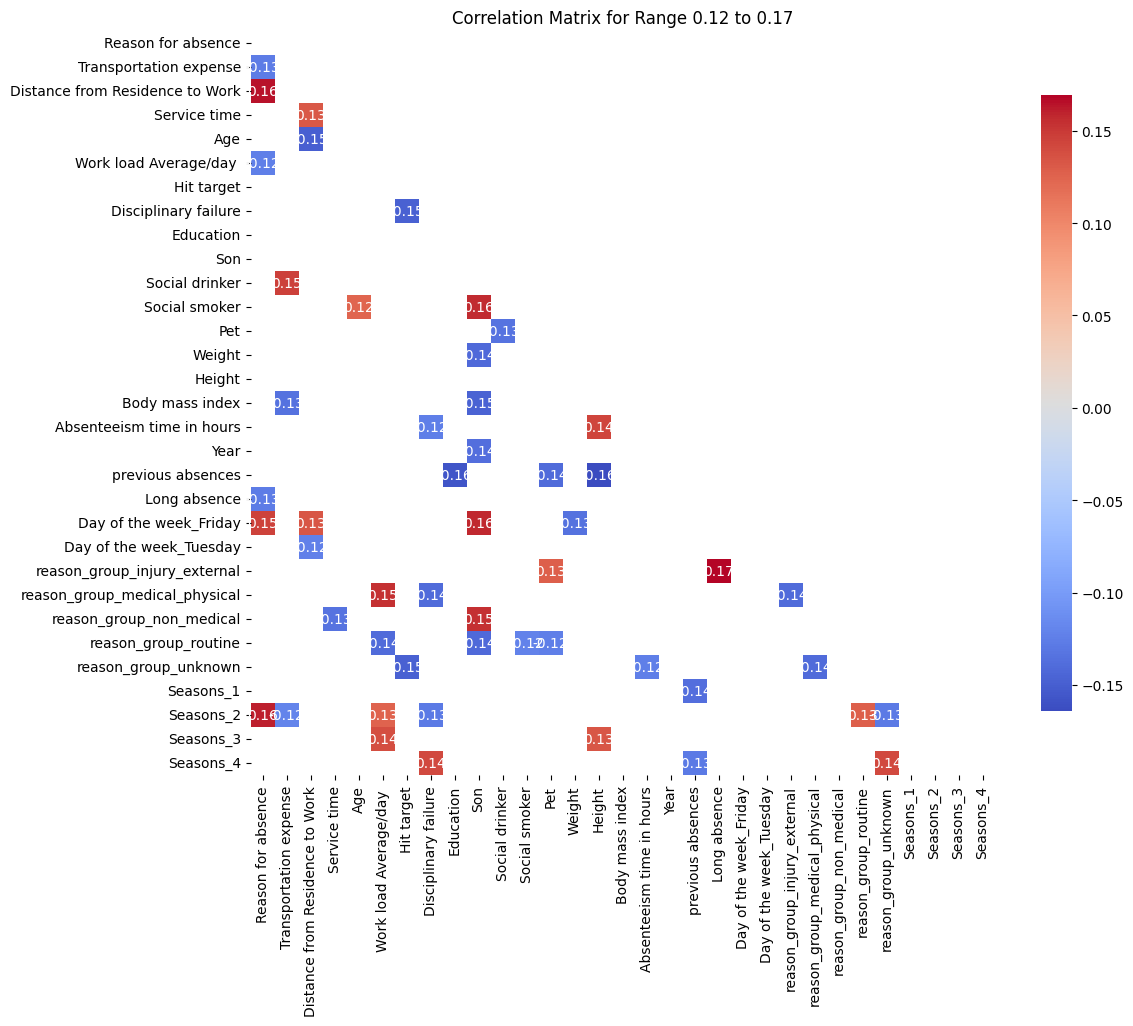

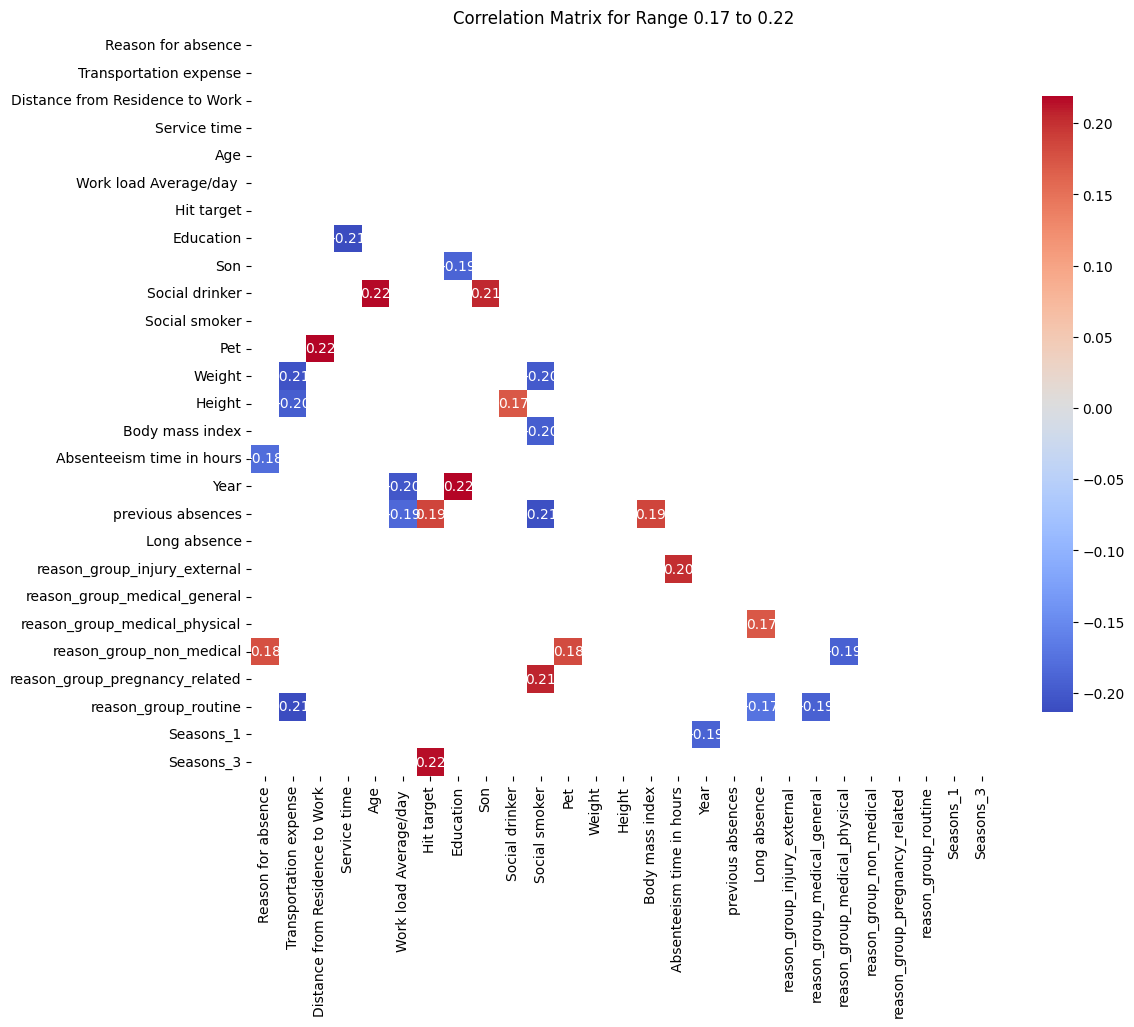

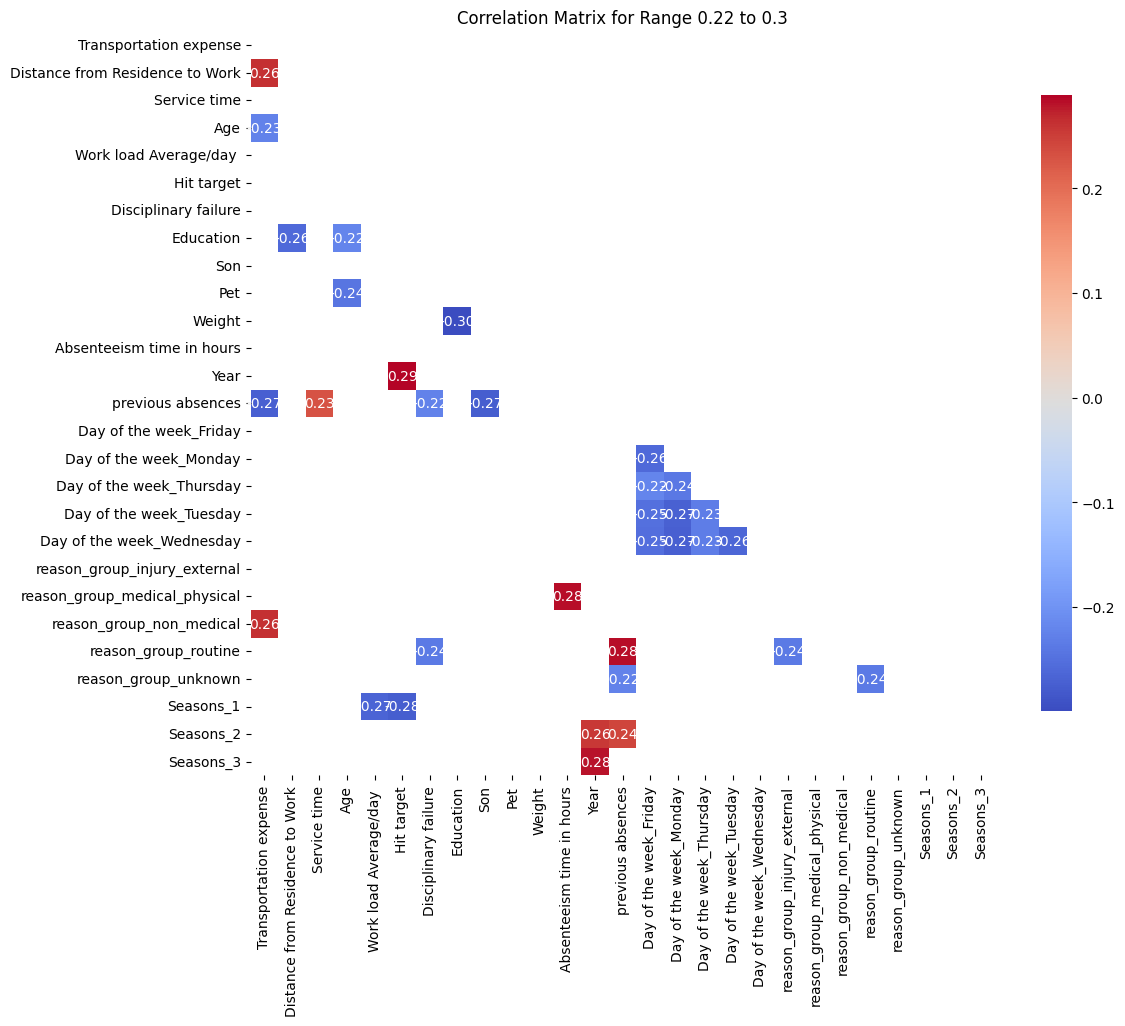

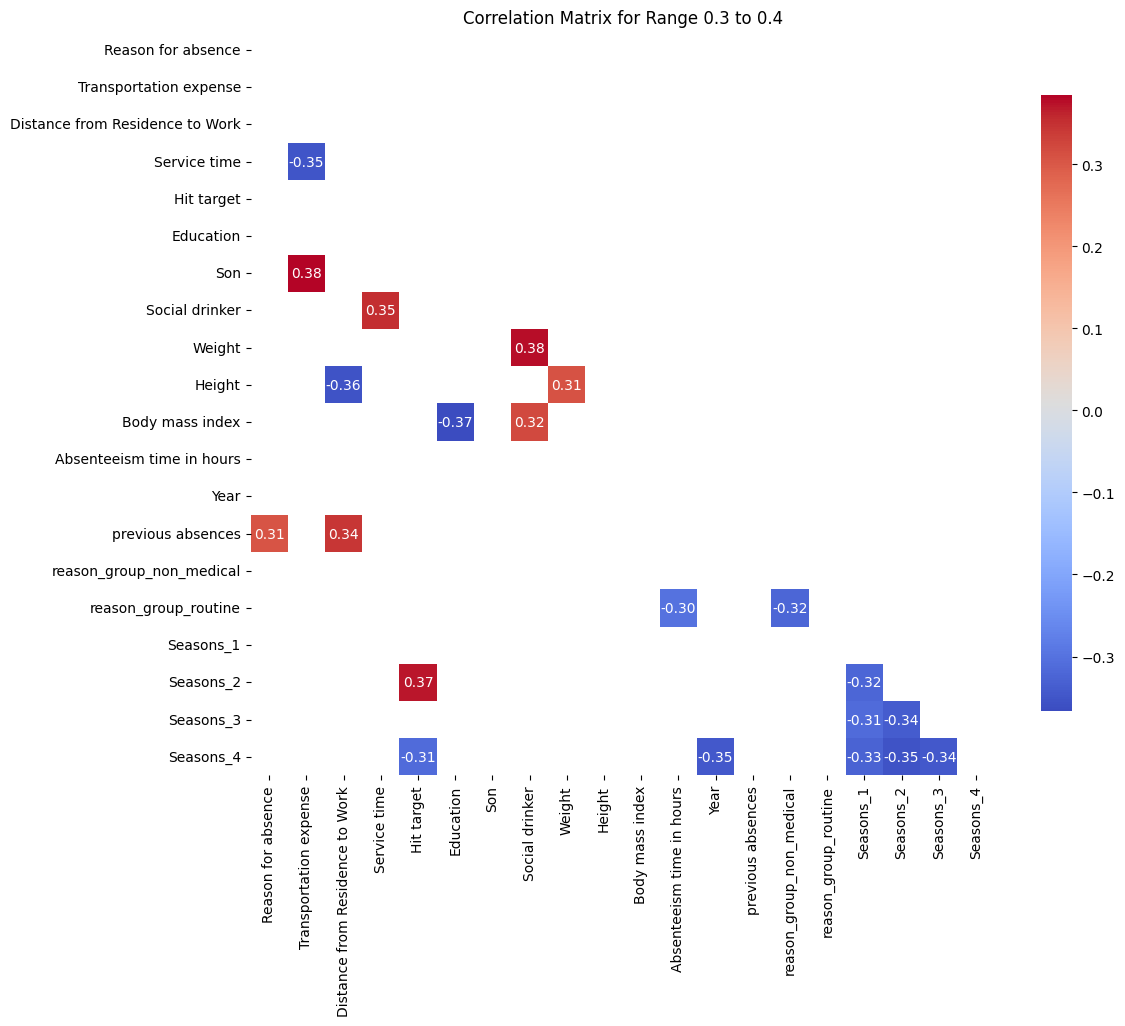

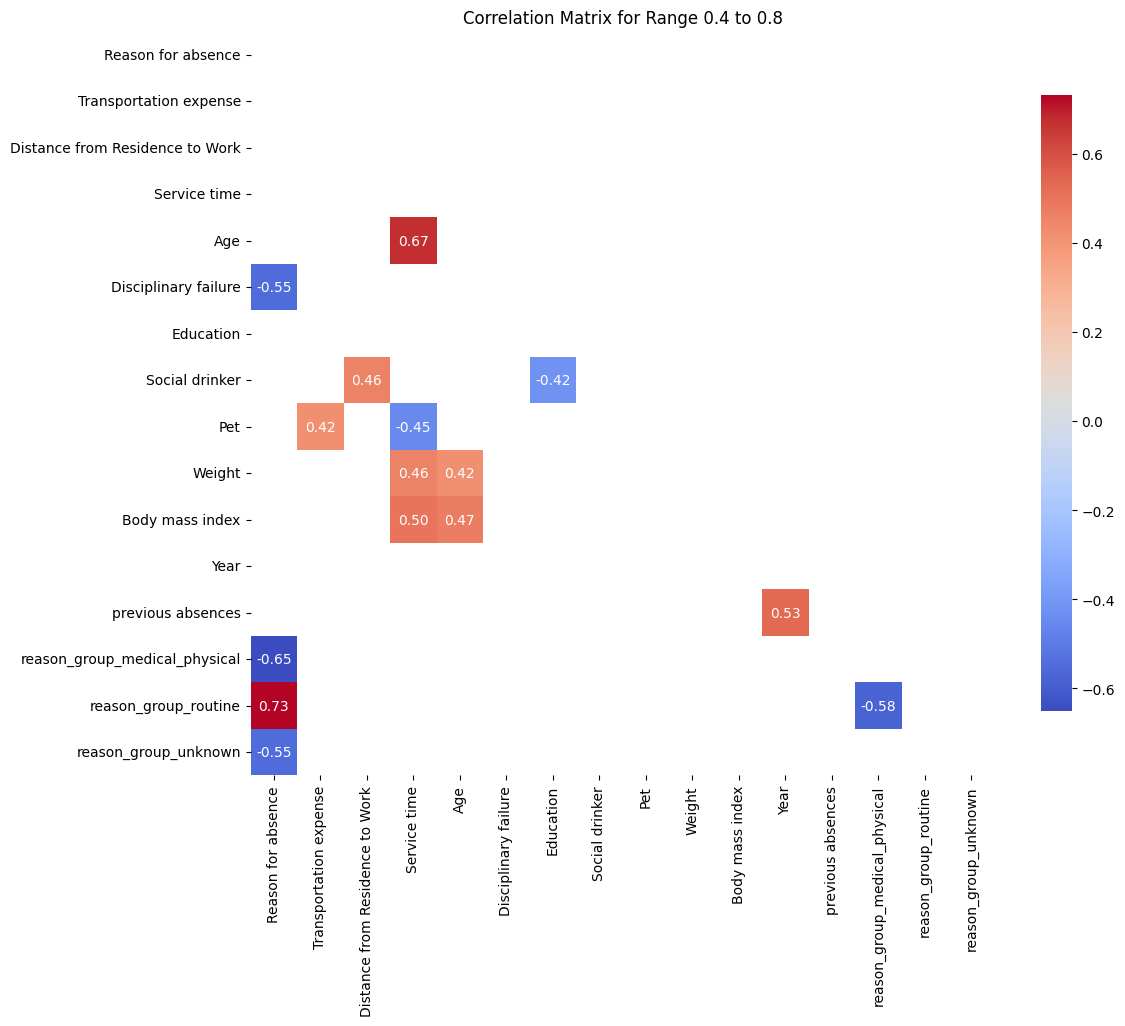

In [ ]:
# find all correlations between the features
import seaborn as sns
import matplotlib.pyplot as plt
df_corr = df.copy()
# drop columns that contain 'Month'
df_corr.drop(list(df_corr.filter(like='Month').columns), axis=1, inplace=True)


correlation_ranges = [[0.08, 0.12], [0.12, 0.17], [0.17, 0.22], [0.22, 0.3], [0.3, 0.4], [0.4, 0.8]]
for corr_range in correlation_ranges:
    corr = df_corr.drop(columns=['ID']).corr()
    corr = corr[(abs(corr) > corr_range[0]) & (abs(corr) < corr_range[1])]
    corr = corr.dropna(axis=0, how='all')
    corr = corr.dropna(axis=1, how='all')
    mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=True, fmt='.2f', square=True, cbar_kws={"shrink": .8})
    plt.title(f'Correlation Matrix for Range {corr_range[0]} to {corr_range[1]}')
    plt.show()



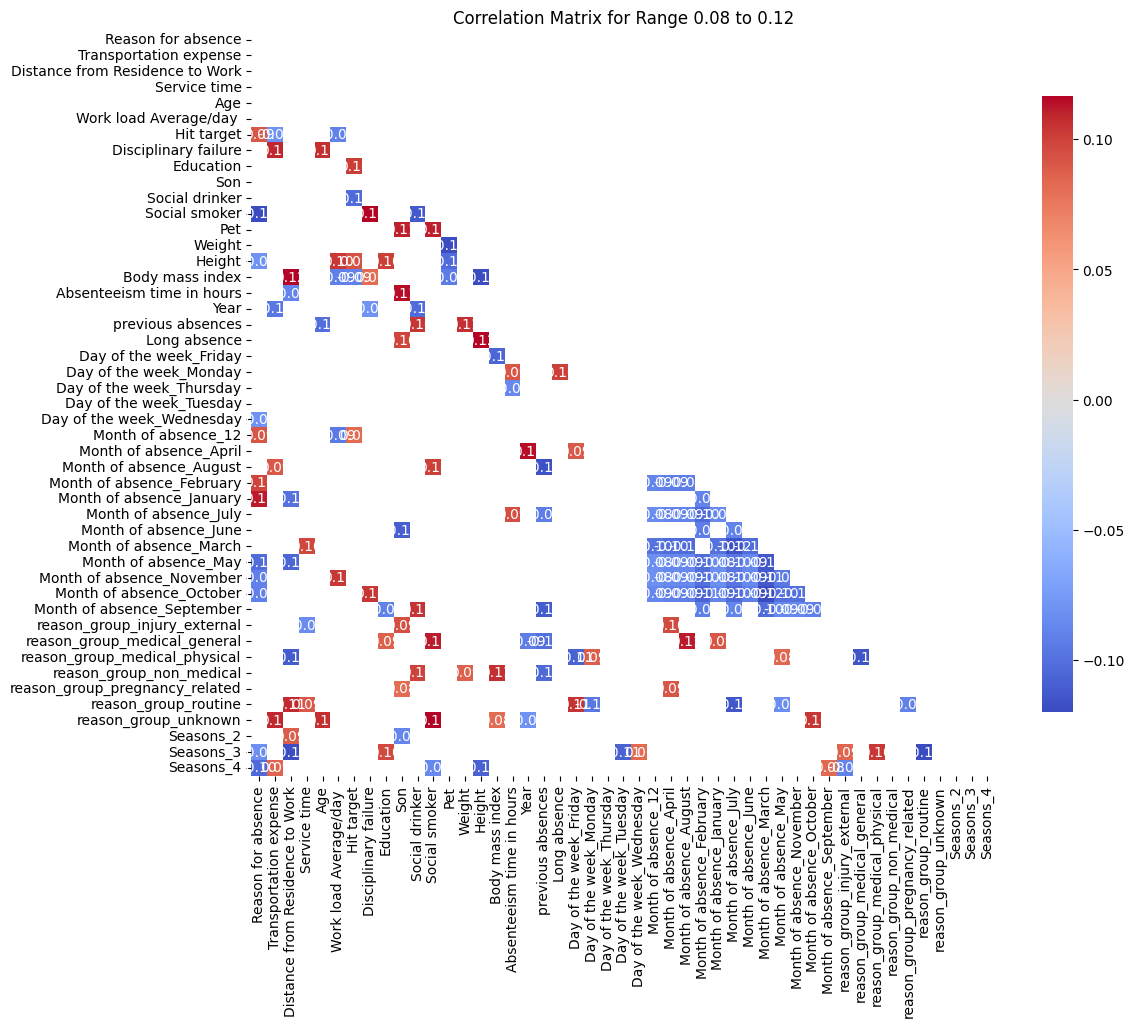

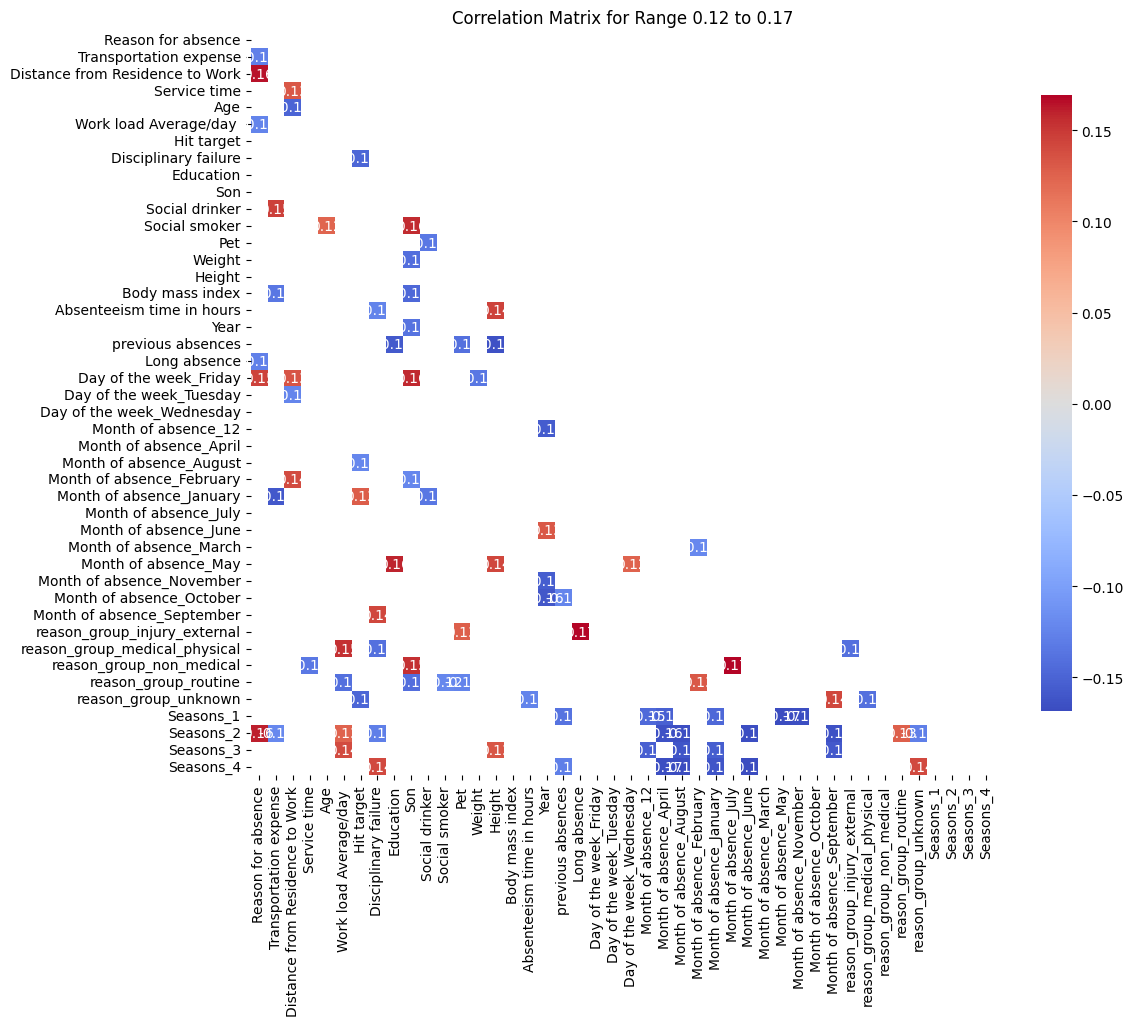

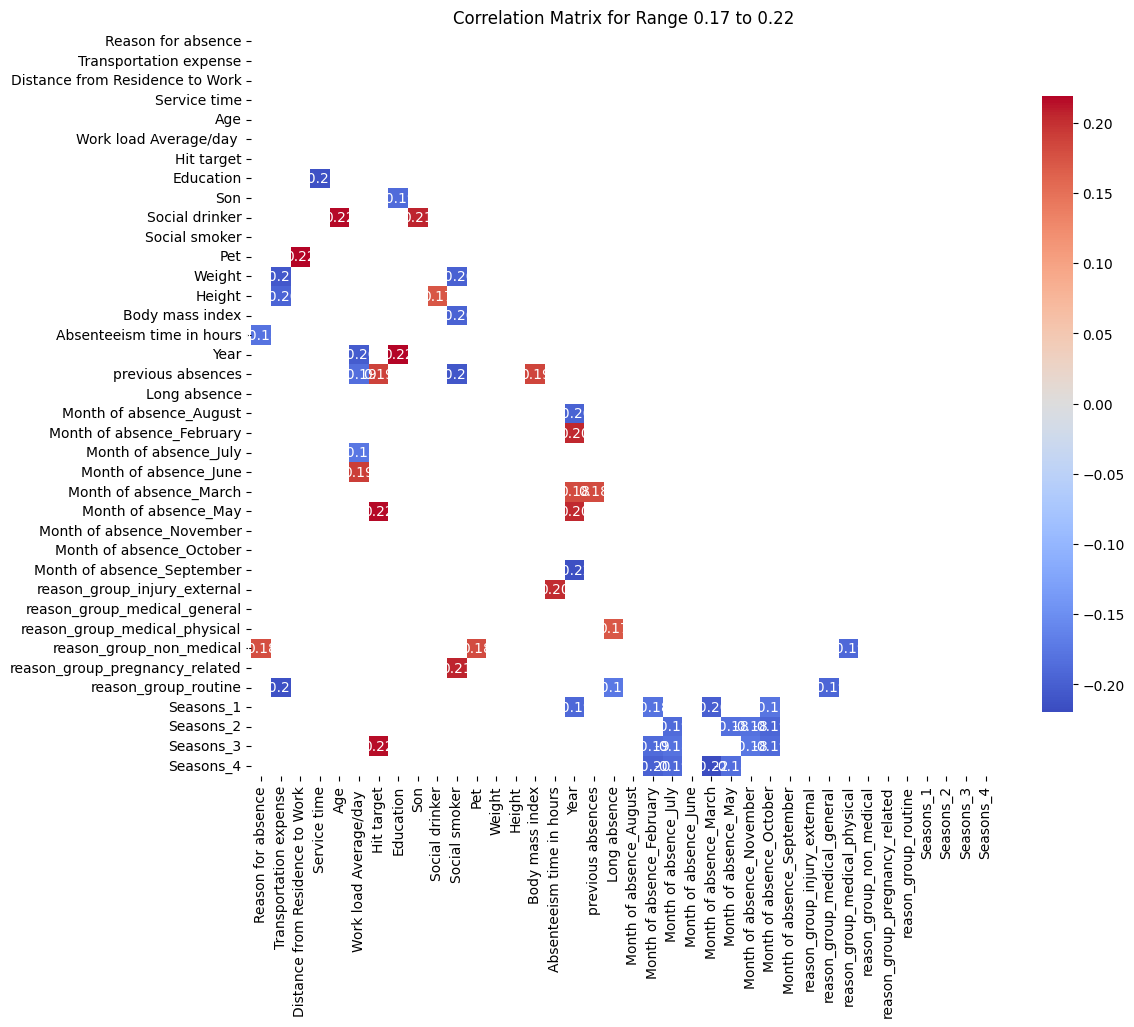

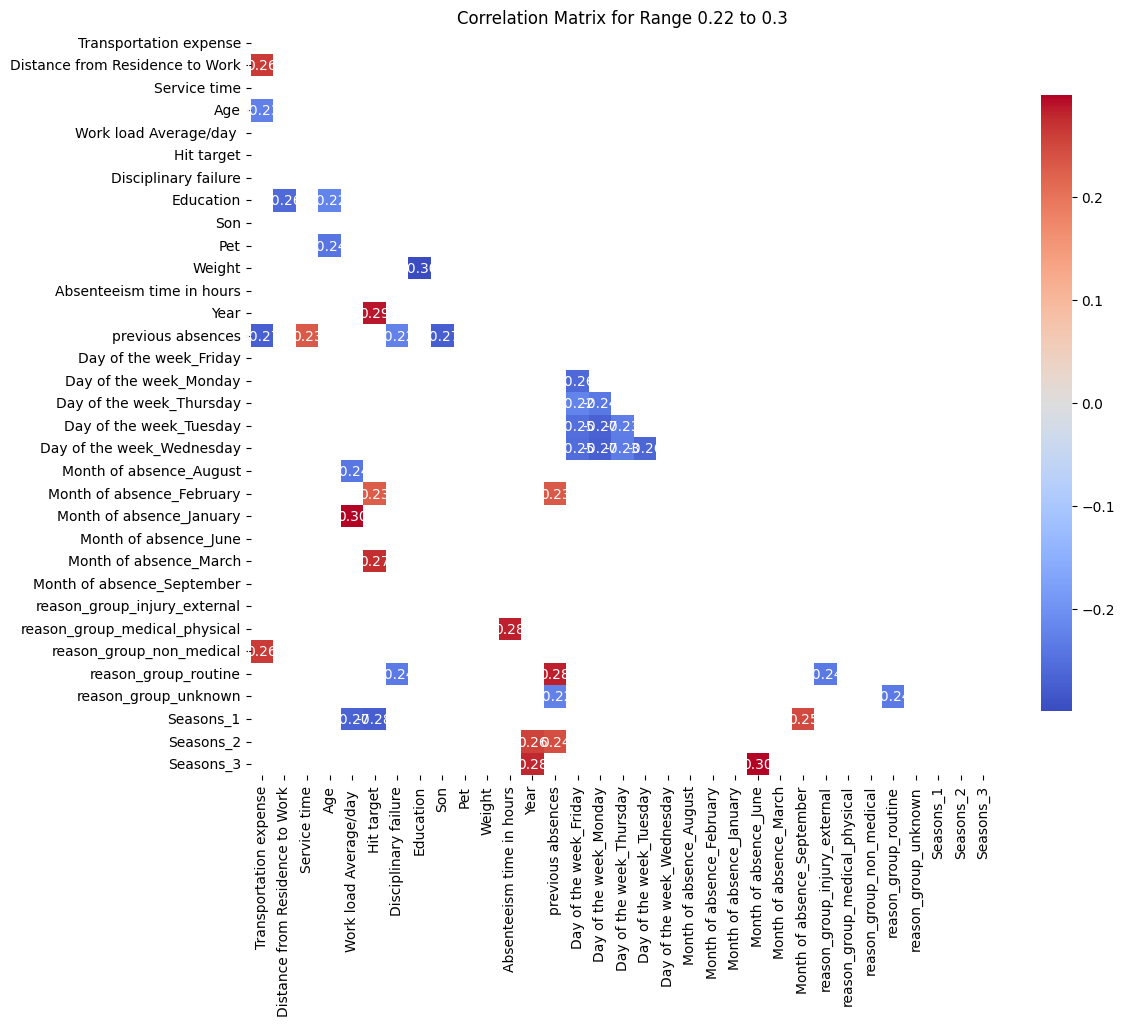

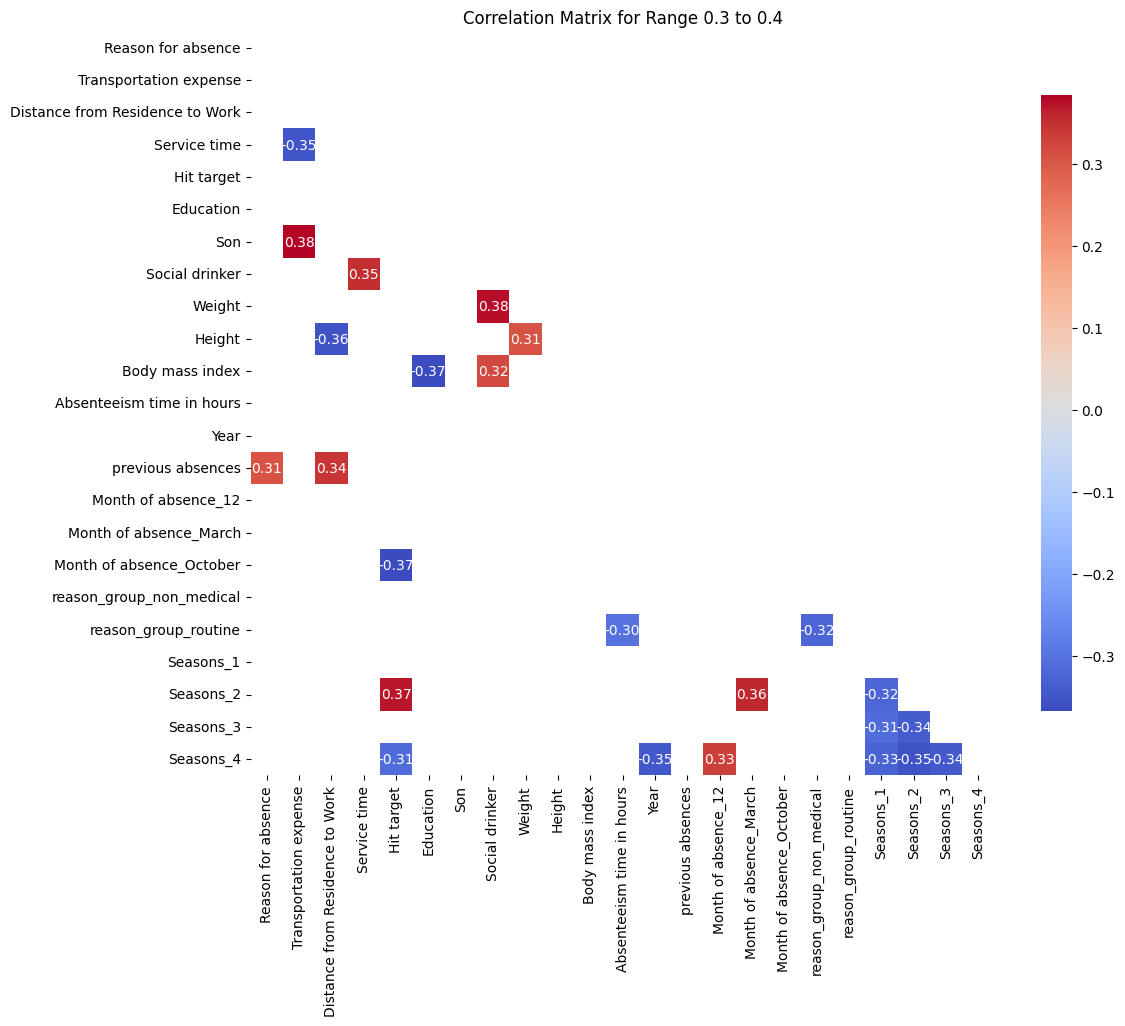

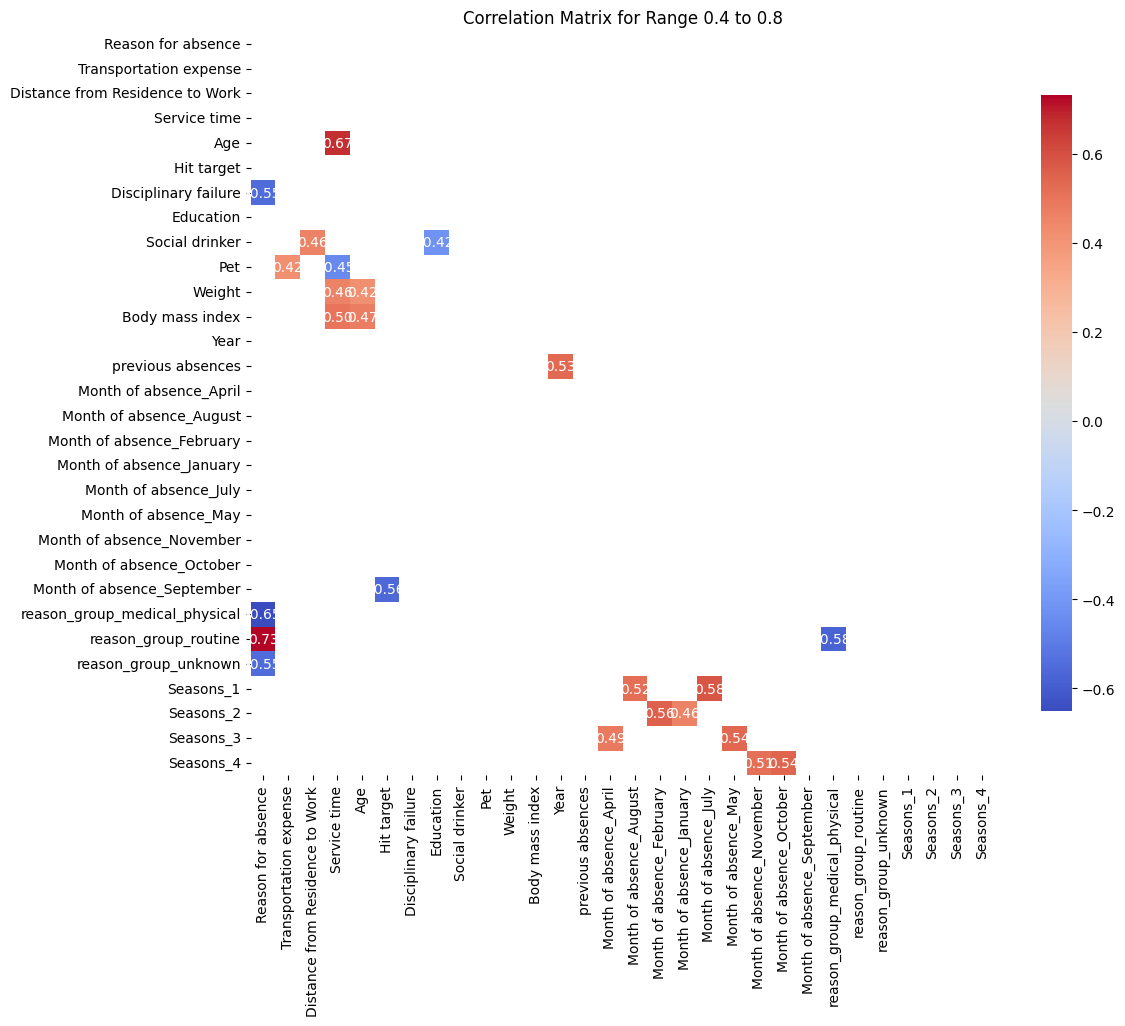

In [ ]:

correlation_ranges = [[0.08, 0.12], [0.12, 0.17], [0.17, 0.22], [0.22, 0.3], [0.3, 0.4], [0.4, 0.8]]
for corr_range in correlation_ranges:
    corr = df.drop(columns=['ID']).corr()
    corr = corr[(abs(corr) > corr_range[0]) & (abs(corr) < corr_range[1])]
    corr = corr.dropna(axis=0, how='all')
    corr = corr.dropna(axis=1, how='all')
    mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=True, fmt='.2f', square=True, cbar_kws={"shrink": .8})
    plt.title(f'Correlation Matrix for Range {corr_range[0]} to {corr_range[1]}')
    plt.show()

